In [1]:
import pandas as pd

splits = {
    'train': 'data/train-00000-of-00001-fcc065bf70ee2231.parquet', 
    'test': 'data/test-00000-of-00001-f1c4bff30406d0d2.parquet', 
    'valid': 'data/valid-00000-of-00001-b738a4243b72ceb5.parquet'
}
df = pd.read_parquet("hf://datasets/tkarr/sprite_caption_dataset/" + splits["train"])
df.head(3)

,image,text
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"Once it takes aim at its foe, it makes a headl..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Their tusks can shatter rocks. Territory battl...
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,The spot patterns on its back grow larger or s...


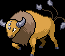

In [6]:
from PIL import Image
from typing import Any
import io
from IPython.display import display

# load the first image and display
image_data: dict[str, Any] = df['image'][0]
image_bytes: bytearray = image_data['bytes']
img = Image.open(io.BytesIO(image_bytes))
display(img)

In [3]:
from matplotlib import pyplot as plt

def get_image_from_dataset(dataset: pd.DataFrame, index: int) -> Image.Image:
    """
    Get a PIL image from a dataset at the specified index.
    
    Args:
        dataset: DataFrame containing image data
        index: Index of the image to retrieve
        
    Returns:
        PIL Image object
    """
    image_data = dataset['image'][index]
    image_bytes = image_data['bytes']
    return Image.open(io.BytesIO(image_bytes))

def viz_compare_images(img1: Image.Image, img2: Image.Image):
    _, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img1)
    axes[0].set_title('Image 1')
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].set_title('Image 2')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

def scale_image(image: Image.Image, factor: float) -> Image.Image | None:
    """Scales a PIL Image down by a factor and returns a new PIL Image.

    Args:
        image: The PIL Image to scale.
        factor: The scaling factor (e.g., 0.5 for half the size).

    Returns:
        A new PIL Image scaled down by the factor, or None if an error occurs.
    """
    try:
        width, height = image.size
        new_width = int(width * factor)
        new_height = int(height * factor)
        scaled_image = image.resize((new_width, new_height), resample=Image.Resampling.NEAREST)
        return scaled_image
    except Exception as e:
        print(f"Error scaling image: {e}")
        return None

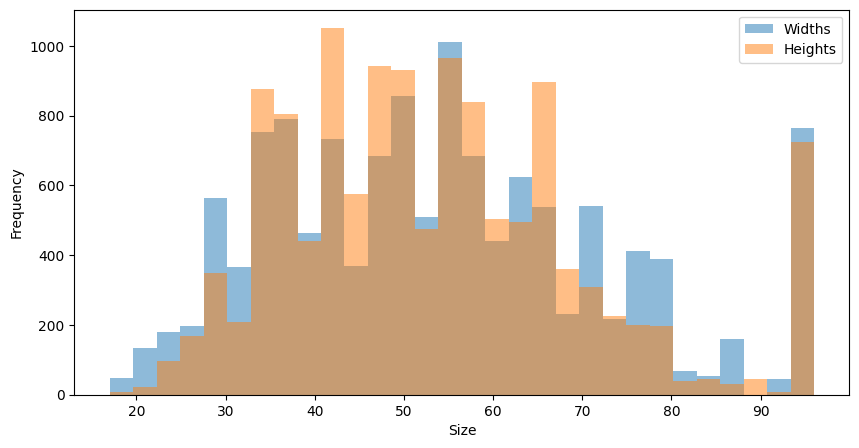

In [4]:
def plot_distribution_of_widths_and_heights(df):
    widths = []
    heights = []
    for i, _ in df.iterrows():
        image = get_image_from_dataset(df, i)
        widths.append(image.width)
        heights.append(image.height)
    plt.figure(figsize=(10, 5))
    plt.hist(widths, bins=30, alpha=0.5, label='Widths')
    plt.hist(heights, bins=30, alpha=0.5, label='Heights')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_distribution_of_widths_and_heights(df)


In [5]:
from tqdm import tqdm
import ipywidgets as widgets

df_sample = df.sample(40)

def analyze_image_quality(scale: int) -> bool:
    n_good = 0
    n_bad = 0
    image_shown = False
    for i, _ in tqdm(df_sample.iterrows()):
        image = get_image_from_dataset(df_sample, i)
        scaled_down_image = scale_image(image, 1/scale)
        scaled_back_up_image = scale_image(scaled_down_image, scale)
        if image.tobytes() == scaled_back_up_image.tobytes():
            n_good += 1
        else:
            n_bad += 1
        if not image_shown:
            viz_compare_images(image, scaled_back_up_image)
            image_shown = True
    print(f"n_good: {n_good}")
    print(f"n_bad: {n_bad}")

image_slider = widgets.IntSlider(
    min=1,
    max=100,
    step=1,
    description='Scale:',
    value=1
)

widgets.interactive(analyze_image_quality, scale=image_slider)

interactive(children=(IntSlider(value=1, description='Scale:', min=1), Output()), _dom_classes=('widget-intera…

## Takeaways
- The images look to be pokemon sprite and all have black backgrounds, so would be interesting to use for training a pokemon pixelart model with the ability to do transparent backgrounds.
- All are already 1x1 pixels, so no need to downscale.
- Most images are within 30x30 to 80x80 width and height.
- The dataset is split into train, test and validation sets, and is pretty big.